# 파이썬을 이용한 비트코인 자동매매


## CH09 웹소켓을 이용한 실시간 시세 처리
- REST API의 요청(request)-응답(reply) 방식은 실시간 데이터를 효과적으로 처리하는데 부족함.
- 웹소켓(websocket)을 이용한 구독(subscribe) 방식으로 가상화폐 거래소의 실시간 데이터를 처리하는 방법 사용

### 9-1. 웹소켓 소개
- REST API의 요청(request)-응답(reply) 방식은 체결 시점의 데이터를 지연 없이 얻기란 불가능
    - 0.1초와 같이 정해진 시간마다 주기적으로 시세를 요청하더라도 최대 0.1초의 지연이 발생함.
- 웹소켓: 프로토콜로 클라이언트(PC)와 서버(거래소 PC) 사이에세ㅓ 실시간 양방향 통신을 위한 기술

### 9-2. asyncio 기초

#### 9-2-1. 동기 호출과 비동기 호출 방식
- 동기(synchronous) 호출 방식

In [3]:
def sync_func1():
    print("Hello")

def sync_func2():
    print("Bye")

sync_func1()
sync_func2()

Hello
Bye


- 비동기처리: 특정 함수가 파일이나 서버로부터 데이터 요청으로 대기가 필요한 경우, 적당한 방식(스케줄링)을 기반으로 요청받은 다른 작업을 먼저 처리하고 있다가 데이터가 준비될 때 다시 기존에 요청받은 함수를 처리하는 방식

#### 9-2-2. 코루틴
- 파이썬에서 어떤 함수가 비동기 방식으로 처리되도록 설정하려면, async 키워드를 사용함.
    - async 키워드가 있는 함수를 코루틴(coroutine)이라고 부름
    

In [4]:
import asyncio

async def async_func1():
    print("Hello")

async_func1()
#asyncio.run(async_func1())

<coroutine object async_func1 at 0x7e00102ba650>

- 이벤트 루프: 여러 코루틴을 처리하기 위한 스케줄러
- 코루틴을 쳐리하기 전에 멈ㄴ저 이벤트 루프를 만들고 코루틴의 처리가 끝난 후에는 이벤트 루프를 닫아줌.
    - asyncio모듈의 run 함수

- Jupyter 노트북 환경에서는 이미 백그라운드에서 이벤트 루프가 실행 중이기 때문에, 별도로 이벤트 루프를 시작하거나 관리할 필요가 없습니다. 따라서 asyncio.get_event_loop(), loop.run_until_complete(), 그리고 loop.close()를 사용하지 않고 비동기 함수를 직접 실행할 수 있습니다.

In [7]:
import asyncio

async def async_func1():
    print("Hello")

# loop = asyncio.get_event_loop()
# loop.run_until_complete(async_func1())
# loop.close()

# 비동기 함수를 실행하기 위해 `await` 사용
await async_func1()

Hello


- 커피 예시를 asyncio를 사용하여 구현

In [9]:
import asyncio

async def make_americano():
    print("Americano Start")
    await asyncio.sleep(3)
    print("Americano End")

async def make_latte():
    print("Latte Start")
    await asyncio.sleep(5)
    print("Latte End")

async def main():
    coro1 = make_americano()
    coro2 = make_latte()
    await asyncio.gather(
        coro1,
        coro2
    )

print("Main Start")
# asyncio.run(main())
await main() # 주피터 노트북 환경
print("Main End")

/usr/lib/python3.10/tokenize.py:527: RuntimeWarning: coroutine 'async_func1' was never awaited
  pseudomatch = _compile(PseudoToken).match(line, pos)


Main Start
Americano Start
Latte Start
Americano End
Latte End
Main End


- 위 코드에서 `Americano Start, Latte Start` 가 동시에 화면에 출력됨.
- 코루틴에서 값을 리턴하도록 변경

In [11]:
import asyncio

async def make_americano():
    print("Americano Start")
    await asyncio.sleep(3)
    print("Americano End")
    return "Americano"

async def make_latte():
    print("Latte Start")
    await asyncio.sleep(5)
    print("Latte End")
    return "Latte"

async def main():
    coro1 = make_americano()
    coro2 = make_latte()
    result = await asyncio.gather(
        coro1,
        coro2
    )
    print(result)

print("Main Start")
# asyncio.run(main())
await main() # 주피터 노트북 환경
print("Main End")

Main Start
Americano Start
Latte Start
Americano End
Latte End
['Americano', 'Latte']
Main End


### 9-3. 프로세스와 스레드 기초

#### 9-3-1. 프로세스와 스레드
- 프로세스: 실행 중인 프로그램
- 스레드: 프로세스의 실행 단위
    - 단일 스레드
    - 다중 스레드
- 프로세스는 실행될 때 운영체제로부터 독립된 자원을 할당받음.
- 한 프로세스가 다른 프로세스의 자원에 접근하려면 프로세스 간 통신으르 사용해야 함.

#### 9-3-2. 스레드 스케줄링
- 운영체제 스케줄링
    - 운영체제는 여러 프로그램을 아주 짧은 시간마다 실행 시켜 줌으로써 마치 동시에 실행되는 것처럼 보이게 함

#### 9-3-3. multiprocessing 모듈
- multiprocessing 모듈의 current_process 함수를 호출하면 현재 실행되는 프로세스에 대한 정보를 담고 있는 객체를 얻을 수 있음.

In [12]:
import multiprocessing as mp


if __name__ == "__main__":
    proc = mp.current_process()
    print(proc.name)
    print(proc.pid)

MainProcess
358


- 프로세스 스포닝(spawning): 부모 프로세스가 운영체제에 요청하여 자식 프로세스를 새로 만들 수 있음.
- multiprocessing 모듈을 이용한 프로세스 스포닝
    - Process 클래스의 인스턴스를 생성한 후 start() 메소드를 호출

In [13]:
import multiprocessing as mp
import time

def worker():
    proc = mp.current_process()
    print(proc.name)
    print(proc.pid)
    time.sleep(5)
    print("SubProcess End")


if __name__ == "__main__":
    # main process
    proc = mp.current_process()
    print(proc.name)
    print(proc.pid)

    # process spawning
    p = mp.Process(name="SubProcess", target=worker)
    p.start()

    print("MainProcess End")

MainProcess
358
MainProcess End
SubProcess
3664


### 9-4. 빗썸 파이썬 웹소켓
- 빗썸 websockets 모듈을 사용하여 빗썸 거래소로부터 실시간 데이터를 수신함.

#### 9-4-1. websockets 모듈 설치

In [1]:
!pip install websockets

#### 9-4-2. 웹소켓 클라이언트
- 빗썸 거래소의 웹소켓 서버에 접근한 후 메시지르르 하나 받아온 후 이를 출력하는 프로그램

In [15]:
import websockets
import asyncio

async def bithumb_ws_client():
    uri = "wss://pubwss.bithumb.com/pub/ws"

    async with websockets.connect(uri) as websocket:
        greeting = await websocket.recv()
        print(greeting)

async def main():
    await bithumb_ws_client()

# asyncio.run(main())
await main() # 주피터 노트북 환경

/usr/local/lib/python3.10/dist-packages/websockets/legacy/http.py:120: RuntimeWarning: coroutine 'async_func1' was never awaited
  status_line = await read_line(stream)
/usr/local/lib/python3.10/dist-packages/websockets/legacy/http.py:120: RuntimeWarning: coroutine 'main' was never awaited
  status_line = await read_line(stream)


{"status":"0000","resmsg":"Connected Successfully"}


#### 9-4-3. 빗썸 거래소 웹소켓 구독하기
- 빗썸 거래소의 웹소켓은 한 번 구독 요첯ㅇ을 하면 계속해서 실시간 데이터를 전송함.
- 빗썸 거래소에 비트코인의 현재가에 대해서 구독 신청하여 계속해서 비트코인의 현재가를 서버로부터 전달받고 출력하는 프로그램

In [16]:
import websockets
import asyncio
import json

async def bithumb_ws_client():
    uri = "wss://pubwss.bithumb.com/pub/ws"

    async with websockets.connect(uri, ping_interval=None) as websocket:
        greeting = await websocket.recv()
        print(greeting)

        subscribe_fmt = {
            "type":"ticker",
            "symbols": ["BTC_KRW"],
            "tickTypes": ["1H"]
        }
        subscribe_data = json.dumps(subscribe_fmt)
        await websocket.send(subscribe_data)

        while True:
            data = await websocket.recv()
            data = json.loads(data)
            print(data)


async def main():
    await bithumb_ws_client()

# asyncio.run(main())
await main() # 주피터 노트북 환경

{"status":"0000","resmsg":"Connected Successfully"}
{'status': '0000', 'resmsg': 'Filter Registered Successfully'}
{'type': 'ticker', 'content': {'volumePower': '209.65', 'chgAmt': '-62000', 'chgRate': '-0.12', 'prevClosePrice': '50021000', 'buyVolume': '109.29962762', 'sellVolume': '52.13536079', 'volume': '161.43498841', 'value': '8090568868.47552', 'highPrice': '50175000', 'lowPrice': '50020000', 'closePrice': '50105000', 'openPrice': '50167000', 'time': '151500', 'date': '20231127', 'tickType': '1H', 'symbol': 'BTC_KRW'}}
{'type': 'ticker', 'content': {'volumePower': '209.61', 'chgAmt': '-61000', 'chgRate': '-0.12', 'prevClosePrice': '50021000', 'buyVolume': '109.30162762', 'sellVolume': '52.14466079', 'volume': '161.44628841', 'value': '8091134921.77552', 'highPrice': '50175000', 'lowPrice': '50020000', 'closePrice': '50106000', 'openPrice': '50167000', 'time': '151501', 'date': '20231127', 'tickType': '1H', 'symbol': 'BTC_KRW'}}
{'type': 'ticker', 'content': {'volumePower': '209.

CancelledError: ignored

#### 9-4-4. 실시간 데이터 출력
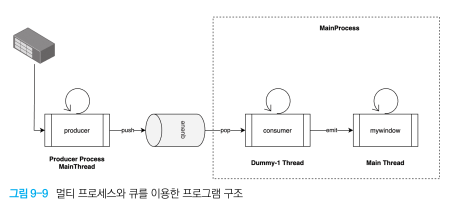

In [2]:
!pip install PyQt5

In [ ]:
# 주피터 노트북에서의 PyQt5 이벤트 루프 충돌로 실행 불가능
import multiprocessing as mp
import websockets
import asyncio
import json
import sys
import datetime
from PyQt5.QtWidgets import *
from PyQt5.QtCore import *


async def bithumb_ws_client(q):
    uri = "wss://pubwss.bithumb.com/pub/ws"

    async with websockets.connect(uri, ping_interval=None) as websocket:
        subscribe_fmt = {
            "type":"ticker",
            "symbols": ["BTC_KRW"],
            "tickTypes": ["1H"]
        }
        subscribe_data = json.dumps(subscribe_fmt)
        await websocket.send(subscribe_data)

        while True:
            data = await websocket.recv()
            data = json.loads(data)
            q.put(data)

async def main(q):
    await bithumb_ws_client(q)

def producer(q):
    asyncio.run(main(q))

class Consumer(QThread):
    poped = pyqtSignal(dict)

    def __init__(self, q):
        super().__init__()
        self.q = q

    def run(self):
        while True:
            if not self.q.empty():
                data = q.get()
                self.poped.emit(data)


class MyWindow(QMainWindow):
    def __init__(self, q):
        super().__init__()
        self.setGeometry(200, 200, 400, 200)
        self.setWindowTitle("Bithumb Websocket with PyQt")

        # thread for data consumer
        self.consumer = Consumer(q)
        self.consumer.poped.connect(self.print_data)
        self.consumer.start()

        # widget
        self.label = QLabel("Bitcoin: ", self)
        self.label.move(10, 10)

        # QLineEdit
        self.line_edit = QLineEdit(" ", self)
        self.line_edit.resize(150, 30)
        self.line_edit.move(100, 10)

    @pyqtSlot(dict)
    def print_data(self, data):
        content = data.get('content')
        if content is not None:
            current_price = int(content.get('closePrice'))
            self.line_edit.setText(format(current_price, ",d"))

        now = datetime.datetime.now()
        self.statusBar().showMessage(str(now))


if __name__ == "__main__":
    q = mp.Queue()
    p = mp.Process(name="Producer", target=producer, args=(q,), daemon=True)
    p.start()

    # Main process
    app = QApplication(sys.argv)
    mywindow = MyWindow(q)
    mywindow.show()
    app.exec_()

#### 9-4-5. pybithumb 모듈을 히용한 실시가나 데이터 출력

In [3]:
!pip install pybithumb

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 5.2 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1257 sha256=1a0b9413e0b43fa45e83c1e3d4a1c0c2c00f2656525cd8d3eb63139fc2a0bfed
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4


In [ ]:
# 주피터 노트북에서의 PyQt5 이벤트 루프 충돌로 실행 불가능
from pybithumb import WebSocketManager
import sys
from PyQt5.QtWidgets import *
from PyQt5.QtCore import *
from PyQt5.QtGui import QIcon
import time


class Worker(QThread):
    recv = pyqtSignal(str)
    def run(self):
        # create websocket for Bithumb
        wm = WebSocketManager("ticker", ["BTC_KRW"])
        while True:
            data = wm.get()
            self.recv.emit(data['content']['closePrice'])


class MyWindow(QMainWindow):
    def __init__(self):
        super().__init__()

        label = QLabel("BTC", self)
        label.move(20, 20)

        self.price = QLabel("-", self)
        self.price.move(80, 20)
        self.price.resize(100, 20)

        button = QPushButton("Start", self)
        button.move(20, 50)
        button.clicked.connect(self.click_btn)

        self.th = Worker()
        self.th.recv.connect(self.receive_msg)

    @pyqtSlot(str)
    def receive_msg(self, msg):
        print(msg)
        self.price.setText(msg)

    def click_btn(self):
       self.th.start()


if __name__ == '__main__':
   app = QApplication(sys.argv)
   mywindow = MyWindow()
   mywindow.show()
   app.exec_()

### 9-5. 코빗 파이썬 웹소켓

#### 9-5-1. 웹소켓 연결

In [5]:
# korbit websocket connection
import websockets
import asyncio

async def korbit_ws_client():
    uri = "wss://ws.korbit.co.kr/v1/user/push"

    async with websockets.connect(uri) as websocket:
        greeting = await websocket.recv()
        print(greeting)

async def main():
    await korbit_ws_client()

# asyncio.run(main())
await main() # 주피터 노트북 환경

{"timestamp":1701067668434,"key":0,"event":"korbit:connected","data":{}}


#### 9-5-2. 채널 구독 요청

In [6]:
# Korbit Websocket Subscribe Example
import websockets
import asyncio
import json
import datetime
import pprint

async def korbit_ws_client():
    uri = "wss://ws.korbit.co.kr/v1/user/push"

    async with websockets.connect(uri) as websocket:
        now = datetime.datetime.now()
        timestamp = int(now.timestamp() * 1000)

        subscribe_fmt = {
            "accessToken": None,
            "timestamp": timestamp,
            "event": "korbit:subscribe",
            "data": {
                "channels": ["ticker:btc_krw"]
            }
        }
        subscribe_data = json.dumps(subscribe_fmt)
        await websocket.send(subscribe_data)

        while True:
            data = await websocket.recv()
            data = json.loads(data)
            pprint.pprint(data)


async def main():
    await korbit_ws_client()

# asyncio.run(main())
await main() # 주피터 노트북 환경

{'data': {}, 'event': 'korbit:connected', 'key': 0, 'timestamp': 1701067703204}
{'data': {'channels': ['ticker:btc_krw']},
 'event': 'korbit:subscribe',
 'timestamp': 1701067703311}
{'data': {'ask': '50143000',
          'bid': '50133000',
          'change': '-383000',
          'channel': 'ticker',
          'currency_pair': 'btc_krw',
          'high': '50800000',
          'last': '50134000',
          'low': '50000000',
          'open': '50517000',
          'timestamp': 1701067654150,
          'volume': '72.99039689'},
 'event': 'korbit:push-ticker',
 'timestamp': 1701067703572}
{'data': {'ask': '50153000',
          'bid': '50133000',
          'change': '-383000',
          'channel': 'ticker',
          'currency_pair': 'btc_krw',
          'high': '50800000',
          'last': '50134000',
          'low': '50000000',
          'open': '50517000',
          'timestamp': 1701067654150,
          'volume': '72.99039689'},
 'event': 'korbit:push-ticker',
 'timestamp': 170106770

CancelledError: ignored

#### 9-5-3. 실시간 데이터 출력

In [ ]:
# 주피터 노트북에서의 PyQt5 이벤트 루프 충돌로 실행 불가능
import multiprocessing as mp
import websockets
import asyncio
import json
import datetime
import sys
from PyQt5.QtWidgets import *
from PyQt5.QtCore import *
import threading

async def korbit_ws_client(q):
    uri = "wss://ws.korbit.co.kr/v1/user/push"

    async with websockets.connect(uri) as websocket:
        now = datetime.datetime.now()
        timestamp = int(now.timestamp() * 1000)

        subscribe_fmt = {
            "accessToken": None,
            "timestamp": timestamp,
            "event": "korbit:subscribe",
            "data": {
                "channels": ["ticker:btc_krw"]
            }
        }
        subscribe_data = json.dumps(subscribe_fmt)
        await websocket.send(subscribe_data)

        while True:
            data = await websocket.recv()
            data = json.loads(data)
            q.put(data)

async def main(q):
    await korbit_ws_client(q)

def producer(q):
    proc = mp.current_process()
    print("producer's Process: ", proc.name)
    print("producer's Thread : ", threading.currentThread().getName())
    asyncio.run(main(q))

class Consumer(QThread):
    poped = pyqtSignal(dict)

    def __init__(self, q):
        super().__init__()
        self.q = q

    def run(self):
        proc = mp.current_process()
        print("consumer's Process: ", proc.name)
        print("consumer's Thread : ", threading.currentThread().getName())

        while True:
            if not self.q.empty():
                data = q.get()
                self.poped.emit(data)


class MyWindow(QMainWindow):
    def __init__(self, q):
        super().__init__()
        self.setGeometry(200, 200, 400, 200)
        self.setWindowTitle("Korbit Websocket")

        # thread for data consumer
        proc = mp.current_process()
        print("windows's Process: ", proc.name)
        print("windows's Thread : ", threading.currentThread().getName())

        self.consumer = Consumer(q)
        self.consumer.poped.connect(self.print_data)
        self.consumer.start()

        # widget
        self.label = QLabel("Bitcoin: ", self)
        self.label.move(10, 10)

        # QLineEdit
        self.line_edit = QLineEdit(" ", self)
        self.line_edit.resize(150, 30)
        self.line_edit.move(100, 10)

    @pyqtSlot(dict)
    def print_data(self, data):
        timestamp = data.get('timestamp')
        data_dict = data.get('data')
        last = data_dict.get('last')

        if last is not None:
            current_price = int(last)
            self.line_edit.setText(format(current_price, ",d"))

        now = datetime.datetime.fromtimestamp(int(timestamp)/1000)
        self.statusBar().showMessage(str(now))


if __name__ == "__main__":
    q = mp.Queue()
    p = mp.Process(name="Producer", target=producer, args=(q,), daemon=True)
    p.start()

    # Main process
    app = QApplication(sys.argv)
    mywindow = MyWindow(q)
    mywindow.show()
    app.exec_()

### 9-6. 업비트 파이썬 웹소켓

#### 9-6-1. 채널 구독 요청

In [7]:
import websockets
import asyncio
import json

async def upbit_ws_client():
    uri = "wss://api.upbit.com/websocket/v1"

    async with websockets.connect(uri) as websocket:
        subscribe_fmt = [
            {"ticket":"test"},
            {
                "type": "ticker",
                "codes":["KRW-BTC"],
                "isOnlyRealtime": True
            },
            {"format":"SIMPLE"}
        ]
        subscribe_data = json.dumps(subscribe_fmt)
        await websocket.send(subscribe_data)

        while True:
            data = await websocket.recv()
            data = json.loads(data)
            print(data)


async def main():
    await upbit_ws_client()

# asyncio.run(main())
await main() # 주피터 노트북 환경

{'ty': 'ticker', 'cd': 'KRW-BTC', 'op': 50210000.0, 'hp': 50446000.0, 'lp': 50060000.0, 'tp': 50156000.0, 'pcp': 50210000.0, 'atp': 40856647663.33459, 'c': 'FALL', 'cp': 54000.0, 'scp': -54000.0, 'cr': 0.001075483, 'scr': -0.001075483, 'ab': 'BID', 'tv': 0.00099688, 'atv': 813.68548345, 'tdt': '20231127', 'ttm': '065025', 'ttms': 1701067825122, 'aav': 472.82576612, 'abv': 340.85971733, 'h52wp': 51323000.0, 'h52wdt': '2023-11-24', 'l52wp': 20700000.0, 'l52wdt': '2022-12-30', 'ms': 'ACTIVE', 'its': False, 'dd': None, 'mw': 'NONE', 'tms': 1701067830042, 'atp24h': 116196525840.30455, 'atv24h': 2312.49129918, 'st': 'REALTIME'}
{'ty': 'ticker', 'cd': 'KRW-BTC', 'op': 50210000.0, 'hp': 50446000.0, 'lp': 50060000.0, 'tp': 50156000.0, 'pcp': 50210000.0, 'atp': 40856657657.92071, 'c': 'FALL', 'cp': 54000.0, 'scp': -54000.0, 'cr': 0.001075483, 'scr': -0.001075483, 'ab': 'BID', 'tv': 0.00019927, 'atv': 813.68568272, 'tdt': '20231127', 'ttm': '065030', 'ttms': 1701067830300, 'aav': 472.82576612, 'a

CancelledError: ignored

#### 9-6-2. 실시간 데이터 출력

In [ ]:
# 주피터 노트북에서의 PyQt5 이벤트 루프 충돌로 실행 불가능
import multiprocessing as mp
import websockets
import asyncio
import json
import sys
from PyQt5.QtWidgets import *
from PyQt5.QtCore import *


async def upbit_ws_client(q):
    uri = "wss://api.upbit.com/websocket/v1"

    async with websockets.connect(uri) as websocket:
        subscribe_fmt = [
            {"ticket":"test"},
            {
                "type": "ticker",
                "codes":["KRW-BTC"],
                "isOnlyRealtime": True
            },
            {"format":"SIMPLE"}
        ]
        subscribe_data = json.dumps(subscribe_fmt)
        await websocket.send(subscribe_data)

        while True:
            data = await websocket.recv()
            data = json.loads(data)
            q.put(data)

async def main(q):
    await upbit_ws_client(q)

def producer(q):
    asyncio.run(main(q))

class Consumer(QThread):
    poped = pyqtSignal(dict)

    def __init__(self, q):
        super().__init__()
        self.q = q

    def run(self):
        while True:
            if not self.q.empty():
                data = q.get()
                self.poped.emit(data)


class MyWindow(QMainWindow):
    def __init__(self, q):
        super().__init__()
        self.setGeometry(200, 200, 400, 200)
        self.setWindowTitle("Upbit Websocket")

        # thread for data consumer
        self.consumer = Consumer(q)
        self.consumer.poped.connect(self.print_data)
        self.consumer.start()

        # widget
        self.label = QLabel("Bitcoin: ", self)
        self.label.move(10, 10)

        # QLineEdit
        self.line_edit = QLineEdit(" ", self)
        self.line_edit.resize(150, 30)
        self.line_edit.move(100, 10)

    @pyqtSlot(dict)
    def print_data(self, data):
        current_price = int(data.get('tp'))
        self.line_edit.setText(format(current_price, ",d"))


if __name__ == "__main__":
    q = mp.Queue()
    p = mp.Process(name="Producer", target=producer, args=(q,), daemon=True)
    p.start()

    # Main process
    app = QApplication(sys.argv)
    mywindow = MyWindow(q)
    mywindow.show()
    app.exec_()

#### 9-6-3. pyupbit 모듈을 이용한 실시간 데이터 출력

In [ ]:
# 주피터 노트북에서의 PyQt5 이벤트 루프 충돌로 실행 불가능
from pyupbit import WebSocketManager
import sys
from PyQt5.QtWidgets import *
from PyQt5.QtCore import *


class Worker(QThread):
    recv = pyqtSignal(dict)

    def run(self):
        # create websocket for Bithumb
        wm = WebSocketManager("ticker", ["KRW-BTC"])
        while True:
            data = wm.get()
            print(data)
            self.recv.emit(data)


class MyWindow(QMainWindow):
    def __init__(self):
        super().__init__()

        label = QLabel("BTC", self)
        label.move(20, 20)

        self.price = QLabel("", self)
        self.price.move(80, 20)
        self.price.resize(100, 20)

        button = QPushButton("Start", self)
        button.move(20, 50)
        button.clicked.connect(self.click_btn)

        self.th = Worker()
        self.th.recv.connect(self.receive_msg)

    @pyqtSlot(dict)
    def receive_msg(self, data):
        print(data)
        close_price = data.get("trade_price")
        self.price.setText(str(close_price))

    def click_btn(self):
       self.th.start()


if __name__ == '__main__':
   app = QApplication(sys.argv)
   mywindow = MyWindow()
   mywindow.show()
   app.exec_()